<a href="https://colab.research.google.com/github/as4401s/OpenCV/blob/main/3_Training_1st_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -uq "/content/drive/My Drive/Final_droplet_dataset.zip" -d "/content/drive/My Drive/PATH_TO_OUTPUT"

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
import math

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

In [8]:
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')
val_df = pd.read_csv('Val.csv')

train_df.head()

,Filename,Labels
0,1hr_1897.png,1
1,3hr_676.png,3
2,4hr_488.png,4
3,2hr_137.png,2
4,0hr_2115.png,0


In [9]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=16, seed=1):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      df - dataframe specifying training data.
      image_dir - directory where image files are held.
      x_col: name of column in df that holds filenames.
      y_cols - list of strings that hold y labels for images.
      batch_size - images per batch to be fed into model during training.
      seed - random seed.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
 
    # normalize images
    image_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                        horizontal_flip=True,
                                        rotation_range = 90,
                                        shear_range=0.2,
                                        zoom_range=0.1,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        fill_mode='nearest', cval=0.0)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed)
    
    return generator

In [10]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, 
                                 sample_size=500, batch_size=16, seed=1):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df - dataframe specifying validation data.
      test_df - dataframe specifying test data.
      train_df - dataframe specifying training data.
      df - dataframe specifying training data.
      image_dir - directory where image files are held.
      x_col: name of column in df that holds filenames.
      y_cols - list of strings that hold y labels for images.
      batch_size - images per batch to be fed into model during training.
      seed - random seed.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col=x_col, 
        y_col=y_cols, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True)
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed)

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed)
    
    return valid_generator, test_generator

In [12]:
IMAGE_DIR = "/content/drive/My Drive/PATH_TO_OUTPUT/Final_droplet_dataset"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Filename", "Labels")
valid_generator, test_generator= get_test_and_valid_generator(val_df, test_df, 
                                                              train_df, IMAGE_DIR, "Filename", "Labels")

Found 19307 validated image filenames.
getting train and valid generators...
Found 19307 validated image filenames.
Found 4138 validated image filenames.
Found 4137 validated image filenames.


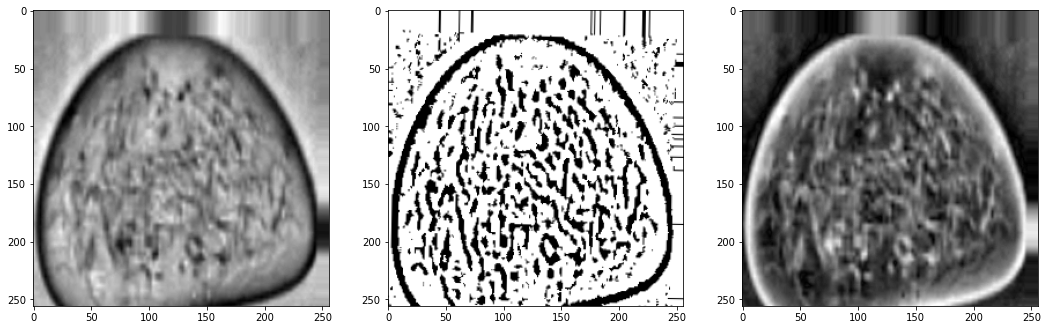

In [13]:
x, y = train_generator.__getitem__(3)
blue, green, red = cv.split(x[0])

fig = plt.figure(figsize = (18, 8))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(blue, cmap = 'gray')
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(green, cmap = 'gray')
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(red, cmap='gray')

In [14]:
# create the base pre-trained model
base_model = EfficientNetB4(weights = 'imagenet',include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
x = Dropout(0.2)(x)

# and a logistic layer
predictions = Dense(7, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

71688192/71686520 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________

In [15]:
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

stopping = EarlyStopping(monitor='val_loss', patience=10)

callbacks = ModelCheckpoint('EfficientNetB4_aug.h5', monitor='val_loss', save_best_only=True, mode = 'auto')

In [ ]:
batch_size = 16

train = 19000
val = 4000
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))

steps_per_epoch = compute_steps_per_epoch(train)
val_steps = compute_steps_per_epoch(val)y

history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=steps_per_epoch, 
                              validation_steps=val_steps, 
                              epochs = 100,
                              callbacks = [callbacks,lr_schedule,stopping])

Epoch 1/100
1188/1188 [==============================] - 675s 528ms/step - loss: 1.3403 - accuracy: 0.7921 - val_loss: 0.9751 - val_accuracy: 0.8242


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
1188/1188 [==============================] - 631s 531ms/step - loss: 0.5888 - accuracy: 0.8947 - val_loss: 0.3264 - val_accuracy: 0.9542
Epoch 3/100
1188/1188 [==============================] - 627s 528ms/step - loss: 0.3976 - accuracy: 0.9316 - val_loss: 0.3373 - val_accuracy: 0.9367
Epoch 4/100
1188/1188 [==============================] - 630s 530ms/step - loss: 0.3155 - accuracy: 0.9464 - val_loss: 0.2883 - val_accuracy: 0.9475
Epoch 5/100
1188/1188 [==============================] - 630s 530ms/step - loss: 0.2756 - accuracy: 0.9531 - val_loss: 0.1476 - val_accuracy: 0.9845
Epoch 6/100
1188/1188 [==============================] - 630s 530ms/step - loss: 0.2288 - accuracy: 0.9630 - val_loss: 0.1978 - val_accuracy: 0.9647
Epoch 7/100
1188/1188 [==============================] - 630s 530ms/step - loss: 0.2023 - accuracy: 0.9673 - val_loss: 0.1324 - val_accuracy: 0.9837
Epoch 8/100
1188/1188 [==============================] - 625s 525ms/step - loss: 0.2108 - accuracy: 0.9649